# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Workspace/FCN

/content/drive/MyDrive/Workspace/FCN


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os, pickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Dataset

## Load Data

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteEV4GO1/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteEV4GO1/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
BATCH_SIZE  = 32
BUFFER_SIZE = 1024

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255. # for faster computation
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'], (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

## Augment Data

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

## Visualize Data

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

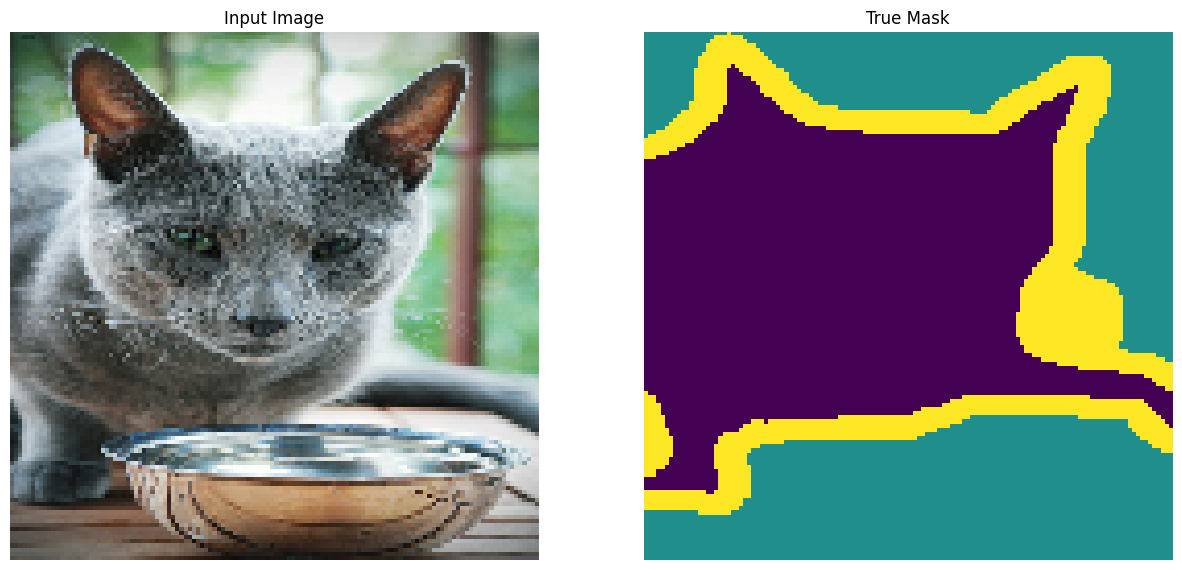

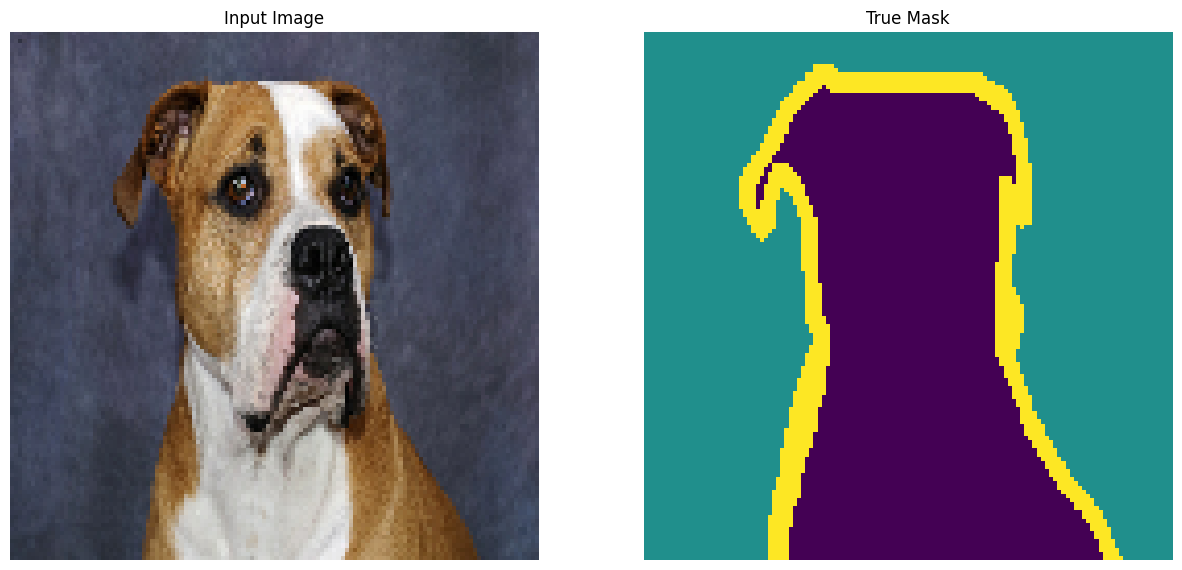

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# FCN

## FCN32s (64s)

In [ ]:
# Bare-bone as Feature Extractor
def fe_fcn32s_model(num_classes, opter, loss_func, metric_list):
  base_model = tf.keras.applications.VGG16(input_shape=[256, 256, 3], include_top=False, weights='imagenet')
  base_model.trainable = False

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  padded_inputs = tf.pad(inputs, ((0, 0), (64, 64), (64, 64), (0, 0)))
  x = base_model(padded_inputs)

  x = tf.keras.layers.Conv2D(512, 7, activation='relu')(x)
  x = tf.keras.layers.Conv2D(512, 1, activation='relu')(x)
  x = tf.keras.layers.Conv2D(num_classes, 1)(x)
  x = tf.keras.layers.Conv2DTranspose(num_classes, 64, 64)(x)

  model = tf.keras.Model(inputs=inputs, outputs=x)
  model.compile(optimizer=opter, loss=loss_func, metrics=metric_list)
  return model

# Bare-bone as Fine-Tuning
def ft_fcn32s_model(num_classes, opter, loss_func, metric_list):
  base_model = tf.keras.applications.VGG16(input_shape=[256, 256, 3], include_top=False, weights='imagenet')
  for layer in base_model.layers[:-4]:
    layer.trainable = False

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  padded_inputs = tf.pad(inputs, ((0, 0), (64, 64), (64, 64), (0, 0)))
  x = base_model(padded_inputs)

  x = tf.keras.layers.Conv2D(512, 7, activation='relu')(x)
  x = tf.keras.layers.Conv2D(512, 1, activation='relu')(x)
  x = tf.keras.layers.Conv2D(num_classes, 1)(x)
  x = tf.keras.layers.Conv2DTranspose(num_classes, 64, 64)(x)

  model = tf.keras.Model(inputs=inputs, outputs=x)
  model.compile(optimizer=opter, loss=loss_func, metrics=metric_list)
  return model

## FCN16s (8s)

In [ ]:
# Bare-bone as Feature Extractor
def fe_fcn16s_model(num_classes, opter, loss_func, metric_list):
  base_model = tf.keras.applications.VGG16(input_shape=[256, 256, 3], include_top=False, weights='imagenet')

  # DownSampling block
  layer_names = [
    'block4_pool',
    'block5_pool',
  ]
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
  down_stack.trainable = False

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  padded_inputs = tf.pad(inputs, ((0, 0), (64, 64), (64, 64), (0, 0)))

  skips = down_stack(padded_inputs)
  pool4 = skips[0]
  pool5 = skips[1]

  pool5 = tf.keras.layers.Conv2D(512, 7, activation='relu')(pool5)
  pool5 = tf.keras.layers.Conv2D(512, 1, activation='relu')(pool5)
  pool5 = tf.keras.layers.Conv2D(num_classes, 1)(pool5)
  pool5 = tf.keras.layers.Conv2DTranspose(num_classes, 8, 8)(pool5)

  pool4 = tf.keras.layers.Conv2D(num_classes, 1)(pool4)
  x = pool4 + pool5
  x = tf.keras.layers.Conv2DTranspose(num_classes, 8, 8)(x)

  model = tf.keras.Model(inputs=inputs, outputs=x)
  model.compile(optimizer=opter, loss=loss_func, metrics=metric_list)
  return model

# Bare-bone as Fine-Tuning
def ft_fcn16s_model(num_classes, opter, loss_func, metric_list):
  base_model = tf.keras.applications.VGG16(input_shape=[256, 256, 3], include_top=False, weights='imagenet')

  # DownSampling block
  layer_names = [
    'block4_pool',
    'block5_pool',
  ]
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
  for layer in down_stack.layers[:-8]:
    layer.trainable = False

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  padded_inputs = tf.pad(inputs, ((0, 0), (64, 64), (64, 64), (0, 0)))

  skips = down_stack(padded_inputs)
  pool4 = skips[0]
  pool5 = skips[1]

  pool5 = tf.keras.layers.Conv2D(512, 7, activation='relu')(pool5)
  pool5 = tf.keras.layers.Conv2D(512, 1, activation='relu')(pool5)
  pool5 = tf.keras.layers.Conv2D(num_classes, 1)(pool5)
  pool5 = tf.keras.layers.Conv2DTranspose(num_classes, 8, 8)(pool5)

  pool4 = tf.keras.layers.Conv2D(num_classes, 1)(pool4)
  x = pool4 + pool5
  x = tf.keras.layers.Conv2DTranspose(num_classes, 8, 8)(x)

  model = tf.keras.Model(inputs=inputs, outputs=x)
  model.compile(optimizer=opter, loss=loss_func, metrics=metric_list)
  return model

## FCN8s (4s)

In [ ]:
# Bare-bone as Feature Extractor
def fe_fcn8s_model(num_classes, opter, loss_func, metric_list):
  base_model = tf.keras.applications.VGG16(input_shape=[256, 256, 3], include_top=False, weights='imagenet')

  # DownSampling block
  layer_names = [
    'block3_pool',
    'block4_pool',
    'block5_pool',
  ]
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
  down_stack.trainable = False

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  padded_inputs = tf.pad(inputs, ((0, 0), (64, 64), (64, 64), (0, 0)))

  skips = down_stack(padded_inputs)
  pool3 = skips[0]
  pool4 = skips[1]
  pool5 = skips[2]

  pool5 = tf.keras.layers.Conv2D(512, 7, activation='relu')(pool5)
  pool5 = tf.keras.layers.Conv2D(512, 1, activation='relu')(pool5)
  pool5 = tf.keras.layers.Conv2D(num_classes, 1)(pool5)
  pool5 = tf.keras.layers.Conv2DTranspose(num_classes, 8, 8)(pool5)

  pool4 = tf.keras.layers.Conv2D(num_classes, 1)(pool4)
  x = pool4 + pool5
  x = tf.keras.layers.Conv2DTranspose(num_classes, 2, 2)(x)

  pool3 = tf.keras.layers.Conv2D(num_classes, 1)(pool3)
  x = x + pool3
  x = tf.keras.layers.Conv2DTranspose(num_classes, 4, 4)(x)

  model = tf.keras.Model(inputs=inputs, outputs=x)
  model.compile(optimizer=opter, loss=loss_func, metrics=metric_list)
  return model

# Bare-bone as Fine-Tuning
def ft_fcn8s_model(num_classes, opter, loss_func, metric_list):
  base_model = tf.keras.applications.VGG16(input_shape=[256,256,3], include_top=False, weights='imagenet')

  # DownSampling block
  layer_names = [
    'block3_pool',
    'block4_pool',
    'block5_pool',
  ]
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
  for layer in down_stack.layers[:-12]:
    layer.trainable = False

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  padded_inputs = tf.pad(inputs, ((0, 0), (64, 64), (64, 64), (0, 0)))

  skips = down_stack(padded_inputs)
  pool3 = skips[0]
  pool4 = skips[1]
  pool5 = skips[2]

  pool5 = tf.keras.layers.Conv2D(512, 7, activation='relu')(pool5)
  pool5 = tf.keras.layers.Conv2D(512, 1, activation='relu')(pool5)
  pool5 = tf.keras.layers.Conv2D(num_classes, 1)(pool5)
  pool5 = tf.keras.layers.Conv2DTranspose(num_classes, 8, 8)(pool5)

  pool4 = tf.keras.layers.Conv2D(num_classes, 1)(pool4)
  x = pool4 + pool5
  x = tf.keras.layers.Conv2DTranspose(num_classes, 2, 2)(x)

  pool3 = tf.keras.layers.Conv2D(num_classes, 1)(pool3)
  x = x + pool3
  x = tf.keras.layers.Conv2DTranspose(num_classes, 4, 4)(x)

  model = tf.keras.Model(inputs=inputs, outputs=x)
  model.compile(optimizer=opter, loss=loss_func, metrics=metric_list)
  return model

# UNet

In [ ]:
def ConvBlock(filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
  conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
  conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
  if pool_layer:
    pool = tf.keras.layers.MaxPooling2D(pool_size)(conv)
    return conv, pool
  else:
    return conv

def UpConvBlock(filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
  conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
  conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
  up = tf.keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
  up = tf.keras.layers.concatenate([up, shared_layer], axis=3)
  return conv, up

In [ ]:
def unet_model(num_classes, opter, loss_func, metric_list):
  inputs = tf.keras.layers.Input([128, 128, 3])

  conv1, pool1 = ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs)
  conv2, pool2 = ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
  conv3, pool3 = ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2)
  conv4, pool4 = ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3)
        
  conv5, up6 = UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
  conv6, up7 = UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
  conv7, up8 = UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
  conv8, up9 = UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
  
  conv9 = ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)

  outputs = tf.keras.layers.Conv2D(num_classes, (3, 3), padding='same')(conv9)
  model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer=opter, loss=loss_func, metrics=metric_list)
  return model

# Train

## Get Model

In [ ]:
def get_opter(opt_name, lr):
  if opt_name == 'adam':
    return tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
  elif opt_name == 'sgd':
    return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0, nesterov=False)

def get_loss_func(loss_name, from_logits=True):
  if loss_name == 'sparse_categorical_crossentropy':
    return tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)

def get_model(num_classes, model_name, opt_params, loss_params, metric_list):
  opter = get_opter(opt_params[0], opt_params[1])
  loss_func = get_loss_func(loss_params[0])

  if model_name == 'fe_fcn32s':
    return fe_fcn32s_model(num_classes, opter, loss_func, metric_list)
  elif model_name == 'ft_fcn32s':
    return ft_fcn32s_model(num_classes, opter, loss_func, metric_list)
  elif model_name == 'fe_fcn16s':
    return fe_fcn16s_model(num_classes, opter, loss_func, metric_list)
  elif model_name == 'ft_fcn16s':
    return ft_fcn16s_model(num_classes, opter, loss_func, metric_list)
  elif model_name == 'fe_fcn8s':
    return fe_fcn8s_model(num_classes, opter, loss_func, metric_list)
  elif model_name == 'ft_fcn8s':
    return ft_fcn8s_model(num_classes, opter, loss_func, metric_list)
  elif model_name == 'unet':
    return unet_model(num_classes, opter, loss_func, metric_list)

In [ ]:
# ===================== MODIFY HERE ===================== #
# OPTIMIZER
OPT_NAME = 'adam'
LR = 0.001

# LOSS FUNCTION
LOSS_NAME = 'sparse_categorical_crossentropy'

# METRICS
METRIC_LIST = ['accuracy']

# MODEL
OUTPUT_CLASSES = 3
MODEL_NAME = 'unet'
# ======================================================= #

In [ ]:
# == MODEL INITIALIZATION == #
model = get_model(
    OUTPUT_CLASSES,
    MODEL_NAME,
    [OPT_NAME, LR],
    [LOSS_NAME],
    METRIC_LIST
)
#tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

# == LOAD LATEST WEIGHTS == #
CHECKPOINT_DIR = f'training_{MODEL_NAME}_{OPT_NAME}_{LR}_{LOSS_NAME}'
if os.path.exists(CHECKPOINT_DIR):
  latest = tf.train.latest_checkpoint(CHECKPOINT_DIR)
  model.load_weights(latest)
  print("Loaded.")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

## Training

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

class EpochModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):
  def __init__(self, filepath, frequency=1, monitor='val_loss', verbose=1,
               save_best_only=False, save_weights_only=True, mode='auto',
               options=None, **kwargs):
    super(EpochModelCheckpoint, self).__init__(filepath, monitor, verbose, save_best_only, 
                                               save_weights_only, mode, "epoch", options)
    self.epochs_since_last_save = 0
    self.frequency = frequency

  def on_epoch_end(self, epoch, logs=None):
    self.epochs_since_last_save += 1
    if self.epochs_since_last_save % self.frequency == 0:
      self._save_model(epoch=epoch, batch=None, logs=logs)

In [ ]:
TRAIN_LENGTH     = info.splits['train'].num_examples
EPOCHS           = 100
STEPS_PER_EPOCH  = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS    = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
CHECKPOINT_PATH  = CHECKPOINT_DIR + "/cp-{epoch:04d}.ckpt"

In [ ]:
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(),
                                     EpochModelCheckpoint(CHECKPOINT_PATH, frequency=10),
                                     tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4,
                                                                      patience=10, verbose=1)
                                    ]
                          )

In [ ]:
# Save history
with open(f'training_{MODEL_NAME}_{OPT_NAME}_{LR}_{LOSS_NAME}.pickle', 'wb') as file_pi:
  pickle.dump(model_history.history, file_pi)

# Analysis *(The bests are Fine-Tuned FCN-16s (8s) and UNet)*

## Load Model

In [ ]:
def load_model(num_classes, model_name, opt_params, loss_params, metric_list):
  model = get_model(num_classes, model_name, opt_params, loss_params, metric_list)
  ckpt_dir = f'training_{model_name}_{opt_params[0]}_{opt_params[1]}_{loss_params[0]}'
  if os.path.exists(ckpt_dir):
    latest = tf.train.latest_checkpoint(ckpt_dir)
    model.load_weights(latest)
    print(ckpt_dir + " is loaded.")
  with open(f'training_{model_name}_{opt_params[0]}_{opt_params[1]}_{loss_params[0]}.pickle', "rb") as file_pi:
    history = pickle.load(file_pi)
  return model, history

In [ ]:
class MyIOU(tf.keras.metrics.IoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, tf.argmax(y_pred, axis=-1), sample_weight)

In [ ]:
a_models, a_histories = [], []
s_models, s_histories = [], []

model_names = ['fe_fcn32s', 'ft_fcn32s', 'fe_fcn16s', 'ft_fcn16s', 'fe_fcn8s', 'ft_fcn8s', 'unet']
opt_params = [['adam', 0.001], ['sgd', 0.001]]
loss_params = [['sparse_categorical_crossentropy']]
metric_list = ['accuracy']

for model_name in model_names:
  model, history = load_model(3, model_name, opt_params[0], loss_params[0], metric_list)
  model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', 
             MyIOU(num_classes=3, target_class_ids=[0,1,2])]
  )
  a_models.append(model)
  a_histories.append(history)

for model_name in model_names:
  model, history = load_model(3, model_name, opt_params[1], loss_params[0], metric_list)
  model.compile(
    metrics=['accuracy', 
             MyIOU(num_classes=3, target_class_ids=[0,1,2])]
  )
  s_models.append(model)
  s_histories.append(history)

58889256/58889256 [==============================] - 2s 0us/step
training_fe_fcn32s_adam_0.001_sparse_categorical_crossentropy is loaded.
training_ft_fcn32s_adam_0.001_sparse_categorical_crossentropy is loaded.
training_fe_fcn16s_adam_0.001_sparse_categorical_crossentropy is loaded.
training_ft_fcn16s_adam_0.001_sparse_categorical_crossentropy is loaded.
training_fe_fcn8s_adam_0.001_sparse_categorical_crossentropy is loaded.
training_ft_fcn8s_adam_0.001_sparse_categorical_crossentropy is loaded.
training_unet_adam_0.001_sparse_categorical_crossentropy is loaded.
training_fe_fcn32s_sgd_0.001_sparse_categorical_crossentropy is loaded.
training_ft_fcn32s_sgd_0.001_sparse_categorical_crossentropy is loaded.
training_fe_fcn16s_sgd_0.001_sparse_categorical_crossentropy is loaded.
training_ft_fcn16s_sgd_0.001_sparse_categorical_crossentropy is loaded.
training_fe_fcn8s_sgd_0.001_sparse_categorical_crossentropy is loaded.
training_ft_fcn8s_sgd_0.001_sparse_categorical_crossentropy is loaded.
t

Trainable parameters of the models: 
 [13146630 20226054 13112460 26091660 13112838 27567366  7760931]
Non-trainable parameters of the models: 
 [14714688.  7635264. 14714688.  1735488. 14714688.   260160.        0.]
Total parameters of the models: 
 [27861318. 27861318. 27827148. 27827148. 27827526. 27827526.  7760931.]


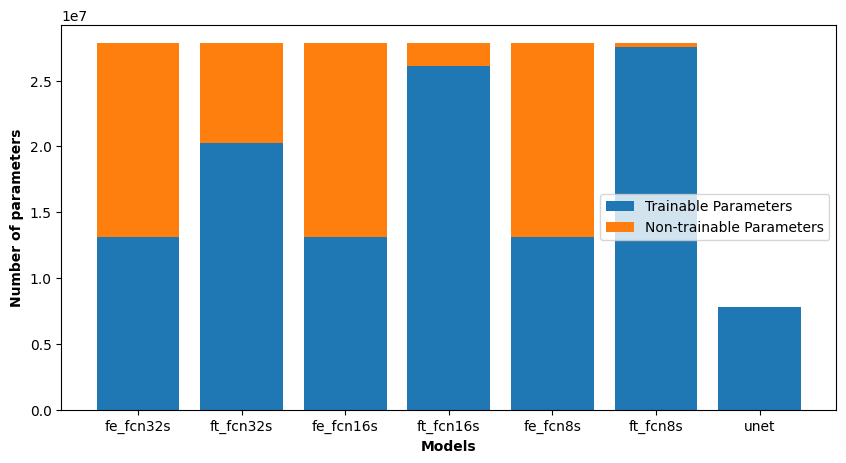

In [ ]:
trainable_params, non_trainable_params = [], []
for model in a_models:
  trainable_params.append(np.sum([np.prod(v.get_shape()) for v in model.trainable_weights]))
  non_trainable_params.append(np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights]))
trainable_params = np.array(trainable_params)
non_trainable_params = np.array(non_trainable_params)
print("Trainable parameters of the models: \n", trainable_params)
print("Non-trainable parameters of the models: \n", non_trainable_params)
print("Total parameters of the models: \n", trainable_params+non_trainable_params)

fig = plt.subplots(figsize =(10, 5))
plt.bar(model_names, trainable_params)
plt.bar(model_names, non_trainable_params, bottom=trainable_params)
plt.xlabel("Models", fontweight ='bold', fontsize = 10)
plt.ylabel("Number of parameters", fontweight ='bold', fontsize = 10)
plt.legend(["Trainable Parameters", "Non-trainable Parameters"])
plt.show()

## Performance

### Loss & accuracy in testing

In [ ]:
a_loss, a_acc, a_miu = [], [], []
for i, model in enumerate(a_models):
  results = model.evaluate(test_batches, batch_size=BATCH_SIZE, verbose=0)
  a_loss.append(results[0])
  a_acc.append(results[1])
  a_miu.append(results[2])

s_loss, s_acc, s_miu = [], [], []
for i, model in enumerate(s_models):
  results = model.evaluate(test_batches, batch_size=BATCH_SIZE, verbose=0)
  s_loss.append(results[0])
  s_acc.append(results[1])
  s_miu.append(results[2])

print("The ordering of models with Adam by acc:")
for id in np.argsort(a_acc):
    print(model_names[id])
print("\nThe ordering of models with SGD by acc:")
for id in np.argsort(s_acc):
    print(model_names[id])
print("\nThe ordering of models with Adam by miu:")
for id in np.argsort(a_miu):
    print(model_names[id])
print("\nThe ordering of models with SGD by miu:")
for id in np.argsort(s_miu):
    print(model_names[id])

The ordering of models with Adam by acc:
fe_fcn8s
fe_fcn32s
fe_fcn16s
ft_fcn32s
ft_fcn8s
ft_fcn16s
unet

The ordering of models with SGD by acc:
unet
fe_fcn32s
ft_fcn32s
fe_fcn16s
fe_fcn8s
ft_fcn8s
ft_fcn16s

The ordering of models with Adam by miu:
fe_fcn32s
fe_fcn16s
fe_fcn8s
ft_fcn32s
ft_fcn8s
ft_fcn16s
unet

The ordering of models with SGD by miu:
fe_fcn32s
ft_fcn32s
unet
fe_fcn16s
fe_fcn8s
ft_fcn8s
ft_fcn16s


<ipython-input-31-031b35ef0c4d>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


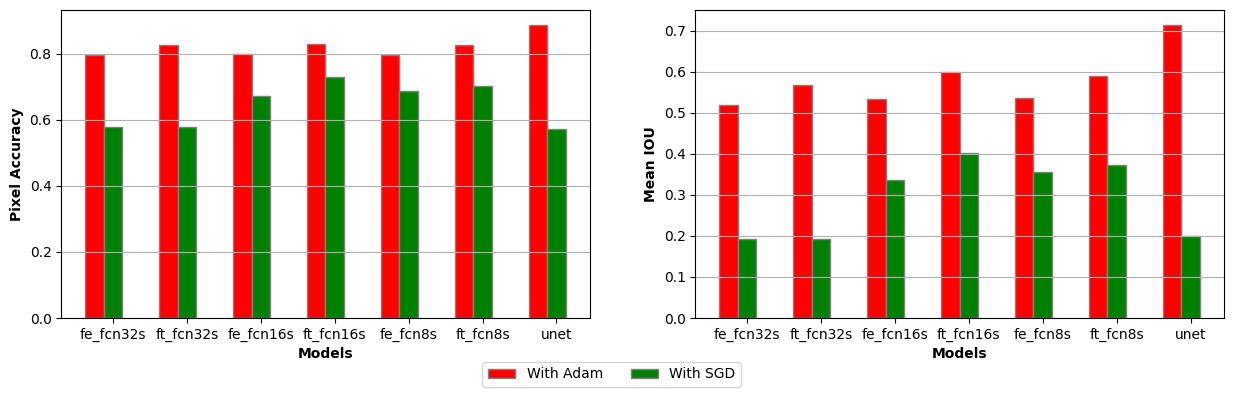

In [ ]:
barWidth = 0.25
fig = plt.subplots(figsize = (15, 4))
 
br1 = np.arange(len(model_names))
br2 = [x + barWidth for x in br1]

#plt.subplot(1, 3, 1)
#plt.bar(br1, a_loss, color ='r', width = barWidth, edgecolor ='grey', label ='With Adam')
#plt.bar(br2, s_loss, color ='g', width = barWidth, edgecolor ='grey', label ='With SGD')
#plt.xlabel('Models', fontweight ='bold', fontsize = 10)
#plt.ylabel('Loss', fontweight ='bold', fontsize = 10)
#plt.xticks([r + barWidth for r in range(len(model_names))], model_names)
#plt.legend()
 
plt.subplot(1, 2, 1)
plt.bar(br1, a_acc, color ='r', width = barWidth, edgecolor ='grey', label ='With Adam')
plt.bar(br2, s_acc, color ='g', width = barWidth, edgecolor ='grey', label ='With SGD')
plt.xlabel('Models', fontweight ='bold', fontsize = 10)
plt.ylabel('Pixel Accuracy', fontweight ='bold', fontsize = 10)
plt.xticks([r + barWidth for r in range(len(model_names))], model_names)
plt.grid(axis='y')
plt.legend(bbox_to_anchor=(1.3, -0.12), ncol=2)

plt.subplot(1, 2, 2)
plt.bar(br1, a_miu, color ='r', width = barWidth, edgecolor ='grey', label ='With Adam')
plt.bar(br2, s_miu, color ='g', width = barWidth, edgecolor ='grey', label ='With SGD')
plt.xlabel('Models', fontweight ='bold', fontsize = 10)
plt.ylabel('Mean IOU', fontweight ='bold', fontsize = 10)
plt.xticks([r + barWidth for r in range(len(model_names))], model_names)
plt.grid(axis='y')
#plt.legend()

plt.show()

### Convergence speed in training

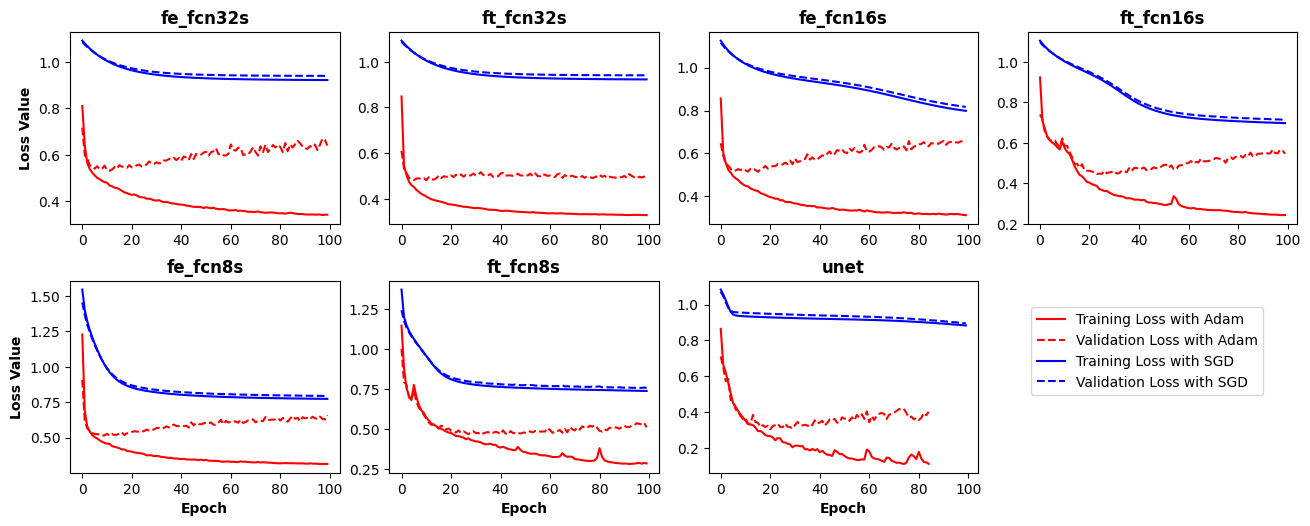

In [ ]:
fig, ax = plt.subplots(2, 4, figsize = (13, 5))
fig.tight_layout(w_pad=0.5, h_pad=2.0)

for i in range(len(model_names)):
  a_loss = a_histories[i]['loss']
  a_val_loss = a_histories[i]['val_loss']
  s_loss = s_histories[i]['loss']
  s_val_loss = s_histories[i]['val_loss']
  l1, = ax[i//4, i%4].plot(range(len(a_loss)), a_loss, 'r')
  l2, = ax[i//4, i%4].plot(range(len(a_val_loss)), a_val_loss, 'r--')
  l3, = ax[i//4, i%4].plot(range(len(s_loss)), s_loss, 'b')
  l4, = ax[i//4, i%4].plot(range(len(s_val_loss)), s_val_loss, 'b--')
  ax[i//4, i%4].set_title(model_names[i], fontweight='bold')
  if i in [4, 5, 6]:
    ax[i//4, i%4].set_xlabel('Epoch', fontweight='bold')
  if i in [0, 4]:
    ax[i//4, i%4].set_ylabel('Loss Value', fontweight='bold')
ax[1, 3].legend([l1, l2, l3, l4], 
                ["Training Loss with Adam", "Validation Loss with Adam", "Training Loss with SGD", "Validation Loss with SGD"], 
                bbox_to_anchor = (0.9, 0.9))
ax[1, 3].axis('off')

plt.show()

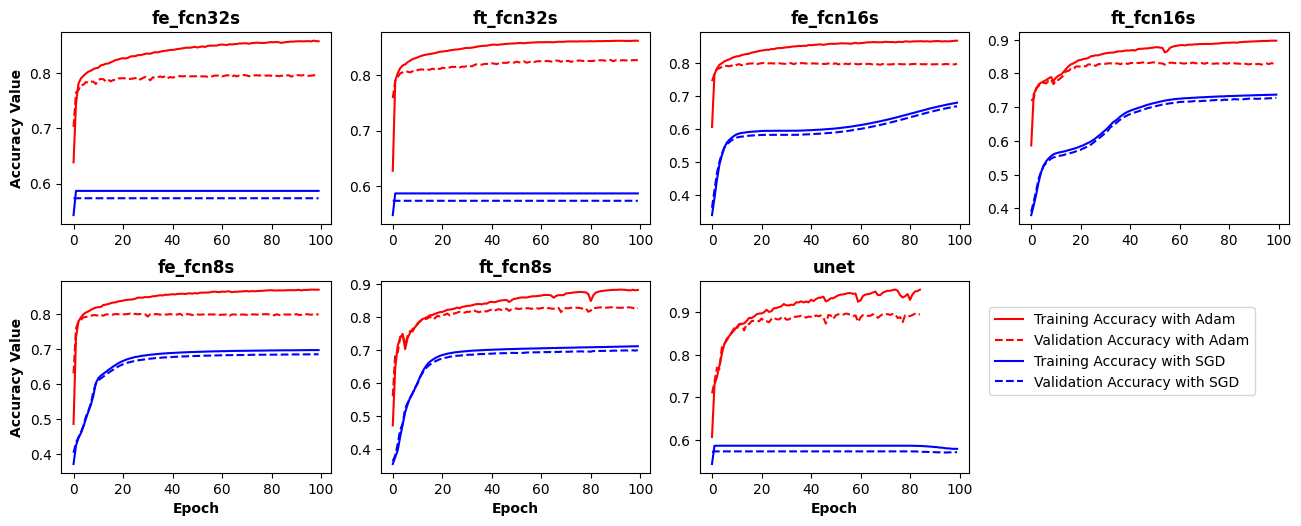

In [ ]:
fig, ax = plt.subplots(2, 4, figsize = (13, 5))
fig.tight_layout(w_pad=0.5, h_pad=2.0)

for i in range(len(model_names)):
  a_acc = a_histories[i]['accuracy']
  a_val_acc = a_histories[i]['val_accuracy']
  s_acc = s_histories[i]['accuracy']
  s_val_acc = s_histories[i]['val_accuracy']
  l1, = ax[i//4, i%4].plot(range(len(a_acc)), a_acc, 'r')
  l2, = ax[i//4, i%4].plot(range(len(a_val_acc)), a_val_acc, 'r--')
  l3, = ax[i//4, i%4].plot(range(len(s_acc)), s_acc, 'b')
  l4, = ax[i//4, i%4].plot(range(len(s_val_acc)), s_val_acc, 'b--')
  ax[i//4, i%4].set_title(model_names[i], fontweight='bold')
  if i in [4, 5, 6]:
    ax[i//4, i%4].set_xlabel('Epoch', fontweight='bold')
  if i in [0, 4]:
    ax[i//4, i%4].set_ylabel('Accuracy Value', fontweight='bold')
ax[1, 3].legend([l1, l2, l3, l4], 
                ["Training Accuracy with Adam", "Validation Accuracy with Adam", "Training Accuracy with SGD", "Validation Accuracy with SGD"], 
                bbox_to_anchor = (0.9, 0.9))
ax[1, 3].axis('off')

plt.show()

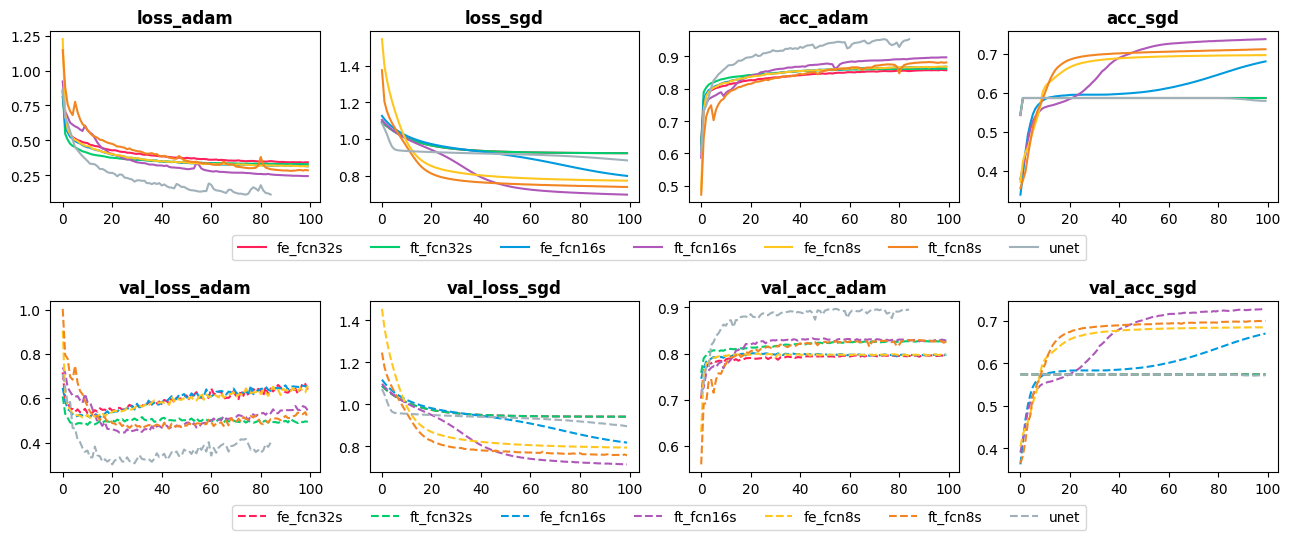

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(13, 5))
fig.tight_layout(w_pad=0.5, h_pad=5.0)
colors = ['#FF1F5B', '#00CD6C', '#009ADE', '#AF58BA', '#FFC61E', '#F28522', '#A0B1BA']

ls, val_ls = [], []
for i in range(len(model_names)):
  a_loss = a_histories[i]['loss']
  l, = ax[0, 0].plot(range(len(a_loss)), a_loss, color=colors[i])
  ls.append(l)
  s_loss = s_histories[i]['loss']
  ax[0, 1].plot(range(len(s_loss)), s_loss, color=colors[i])
  a_acc = a_histories[i]['accuracy']
  ax[0, 2].plot(range(len(a_acc)), a_acc, color=colors[i])
  s_acc = s_histories[i]['accuracy']
  ax[0, 3].plot(range(len(s_acc)), s_acc, color=colors[i])
  a_val_loss = a_histories[i]['val_loss']
  val_l, = ax[1, 0].plot(range(len(a_val_loss)), a_val_loss, color=colors[i], linestyle='dashed')
  val_ls.append(val_l)
  s_val_loss = s_histories[i]['val_loss']
  ax[1, 1].plot(range(len(s_val_loss)), s_val_loss, color=colors[i], linestyle='dashed')
  a_val_acc = a_histories[i]['val_accuracy']
  ax[1, 2].plot(range(len(a_val_acc)), a_val_acc, color=colors[i], linestyle='dashed')
  s_val_acc = s_histories[i]['val_accuracy']
  ax[1, 3].plot(range(len(s_val_acc)), s_val_acc, color=colors[i], linestyle='dashed')

ax[0, 0].set_title('loss_adam', fontweight='bold')
ax[0, 1].set_title('loss_sgd', fontweight='bold')
ax[0, 2].set_title('acc_adam', fontweight='bold')
ax[0, 3].set_title('acc_sgd', fontweight='bold')
ax[0, 2].legend(ls, model_names, bbox_to_anchor=(1.5, -0.15), ncol=len(model_names))

ax[1, 0].set_title('val_loss_adam', fontweight='bold')
ax[1, 1].set_title('val_loss_sgd', fontweight='bold')
ax[1, 2].set_title('val_acc_adam', fontweight='bold')
ax[1, 3].set_title('val_acc_sgd', fontweight='bold')
ax[1, 2].legend(val_ls, model_names, bbox_to_anchor=(1.5, -0.15), ncol=len(model_names))

plt.show()

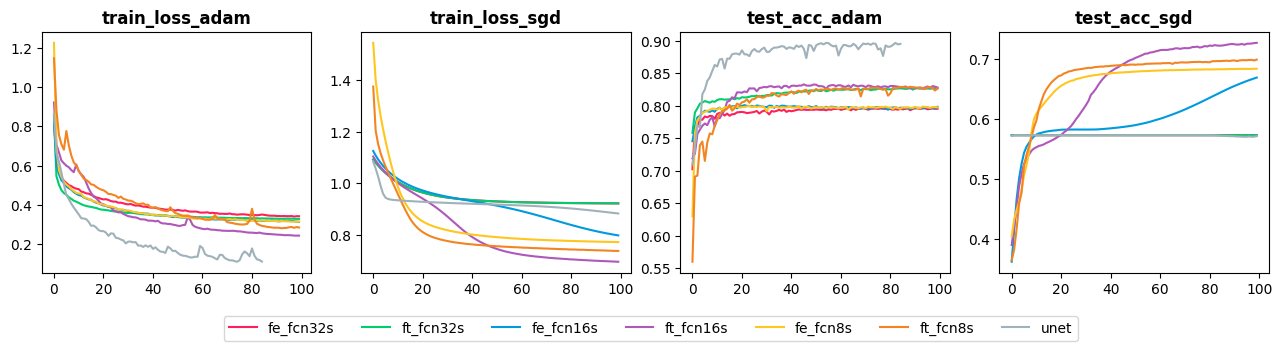

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
fig.tight_layout(w_pad=0.5, h_pad=5.0)
colors = ['#FF1F5B', '#00CD6C', '#009ADE', '#AF58BA', '#FFC61E', '#F28522', '#A0B1BA']

ls, val_ls = [], []
for i in range(len(model_names)):
  a_loss = a_histories[i]['loss']
  l, = ax[0].plot(range(len(a_loss)), a_loss, color=colors[i])
  ls.append(l)
  s_loss = s_histories[i]['loss']
  ax[1].plot(range(len(s_loss)), s_loss, color=colors[i])
  #a_acc = a_histories[i]['accuracy']
  #ax[0, 2].plot(range(len(a_acc)), a_acc, color=colors[i])
  #s_acc = s_histories[i]['accuracy']
  #ax[0, 3].plot(range(len(s_acc)), s_acc, color=colors[i])
  #a_val_loss = a_histories[i]['val_loss']
  #val_l, = ax[1, 0].plot(range(len(a_val_loss)), a_val_loss, color=colors[i], linestyle='dashed')
  #val_ls.append(val_l)
  #s_val_loss = s_histories[i]['val_loss']
  #ax[1, 1].plot(range(len(s_val_loss)), s_val_loss, color=colors[i], linestyle='dashed')
  a_val_acc = a_histories[i]['val_accuracy']
  ax[2].plot(range(len(a_val_acc)), a_val_acc, color=colors[i])
  s_val_acc = s_histories[i]['val_accuracy']
  ax[3].plot(range(len(s_val_acc)), s_val_acc, color=colors[i])

ax[0].set_title('train_loss_adam', fontweight='bold')
ax[1].set_title('train_loss_sgd', fontweight='bold')
ax[2].set_title('test_acc_adam', fontweight='bold')
ax[3].set_title('test_acc_sgd', fontweight='bold')
ax[2].legend(ls, model_names, bbox_to_anchor=(1.5, -0.15), ncol=len(model_names))

#ax[1, 0].set_title('val_loss_adam', fontweight='bold')
#ax[1, 1].set_title('val_loss_sgd', fontweight='bold')
#ax[1, 2].set_title('val_acc_adam', fontweight='bold')
#ax[1, 3].set_title('val_acc_sgd', fontweight='bold')
#ax[1, 2].legend(val_ls, model_names, bbox_to_anchor=(1.5, -0.15), ncol=len(model_names))

plt.show()

## Visualizing Predictions

### FCN (Fine-Tuning & 16s)

1/1 [==============================] - 0s 48ms/step


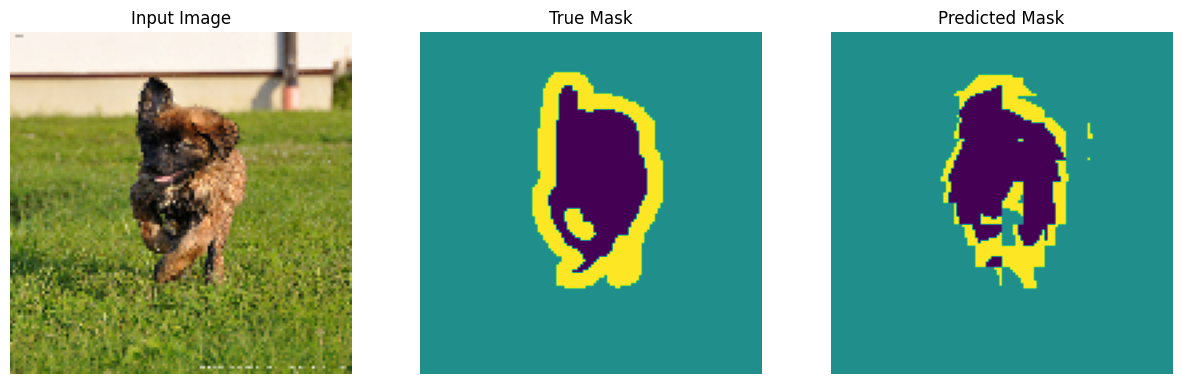

In [ ]:
model = a_models[3]
show_predictions(test_batches, 1)

### FCN (Feature Extractor & 16s)

1/1 [==============================] - 0s 57ms/step


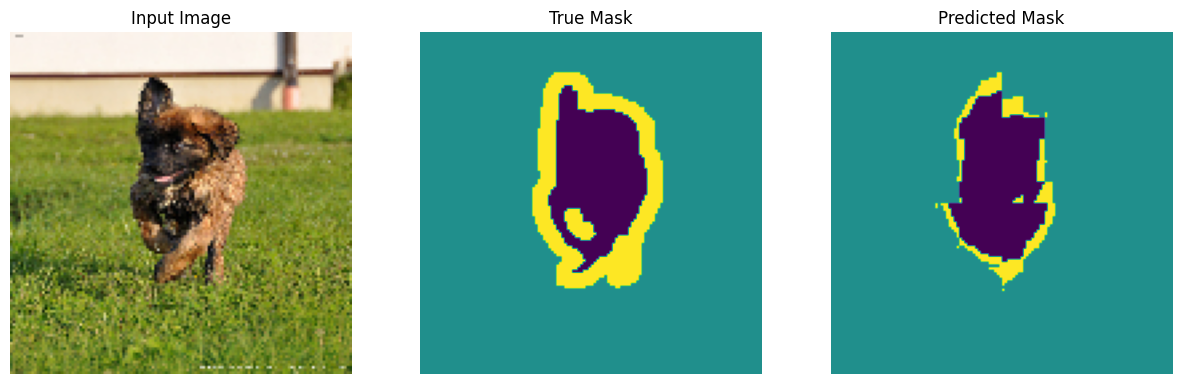

In [ ]:
model = a_models[2]
show_predictions(test_batches, 1)

### UNet

1/1 [==============================] - 0s 39ms/step


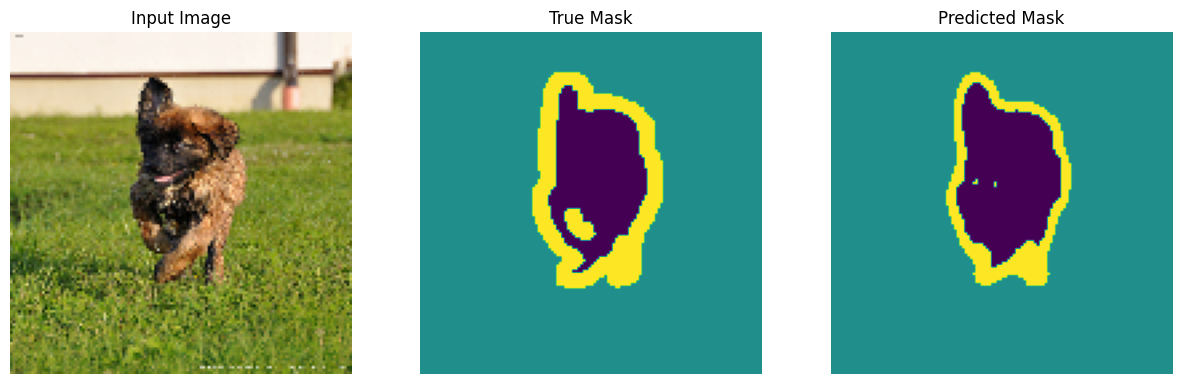

In [ ]:
model = a_models[6]
show_predictions(test_batches, 1)

## Kernels

### FCN (Fine-Tuning & 16s)

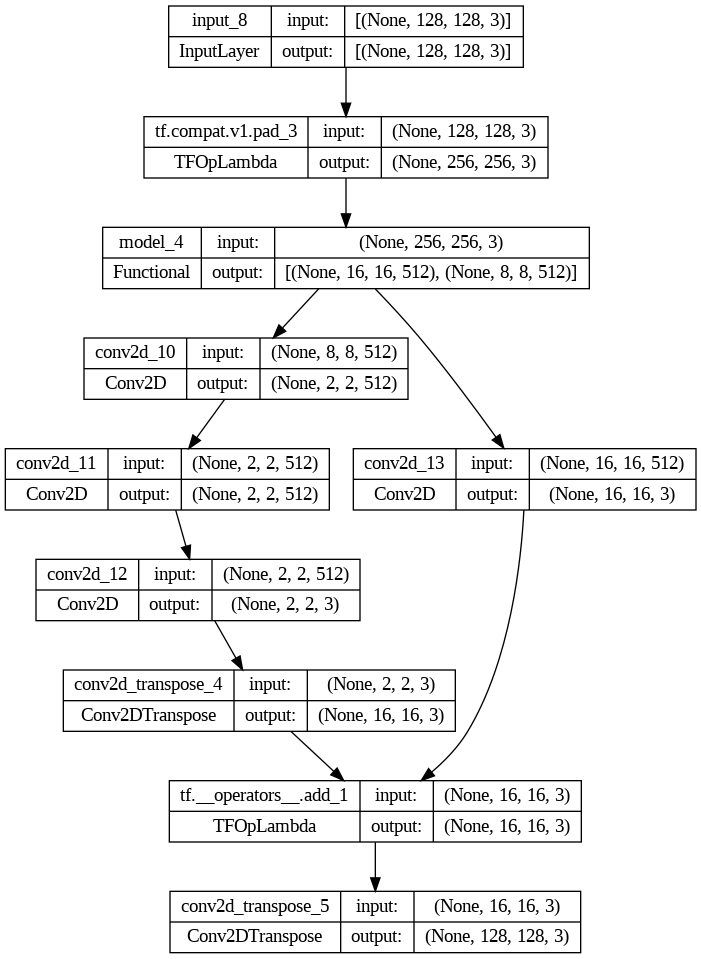

In [ ]:
tf.keras.utils.plot_model(a_models[3], show_shapes=True)

In [ ]:
for i, layer in enumerate(a_models[-2].layers):
  if 'conv' not in layer.name:
    continue
  filters, bias = layer.get_weights()
  print(i, layer.name, filters.shape)

In [ ]:
# retrieve weights from the second hidden layer
filters, bias = a_models[-2].layers[12].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 3
ix = 1
fig = plt.figure(figsize=(20, 15))
for i in range(n_filters):
  f = filters[:,:,:,i]
  for j in range(3):
    plt.subplot(n_filters, 3, ix)
    plt.title(f"{i}-th filter, {j}-th channel")
    plt.imshow(f[:,:,j], cmap='gray')
    ix += 1
fig.tight_layout()
plt.show()

### FCN (Feature Extractor & 16s)

In [ ]:
for i, layer in enumerate(a_models[2].layers):
  if 'conv' not in layer.name:
    continue
  filters, bias = layer.get_weights()
  print(i, layer.name, filters.shape)

3 conv2d_6 (7, 7, 512, 512)
4 conv2d_7 (1, 1, 512, 512)
5 conv2d_8 (1, 1, 512, 3)
6 conv2d_9 (1, 1, 512, 3)
7 conv2d_transpose_2 (8, 8, 3, 3)
9 conv2d_transpose_3 (8, 8, 3, 3)


In [ ]:
# retrieve weights from the second hidden layer
filters, bias = a_models[-3].layers[12].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 3
ix = 1
fig = plt.figure(figsize=(20, 15))
for i in range(n_filters):
  f = filters[:,:,:,i]
  for j in range(3):
    plt.subplot(n_filters, 3, ix)
    plt.title(f"{i}-th filter, {j}-th channel")
    plt.imshow(f[:,:,j], cmap='gray')
    ix += 1
fig.tight_layout()
plt.show()

### UNet

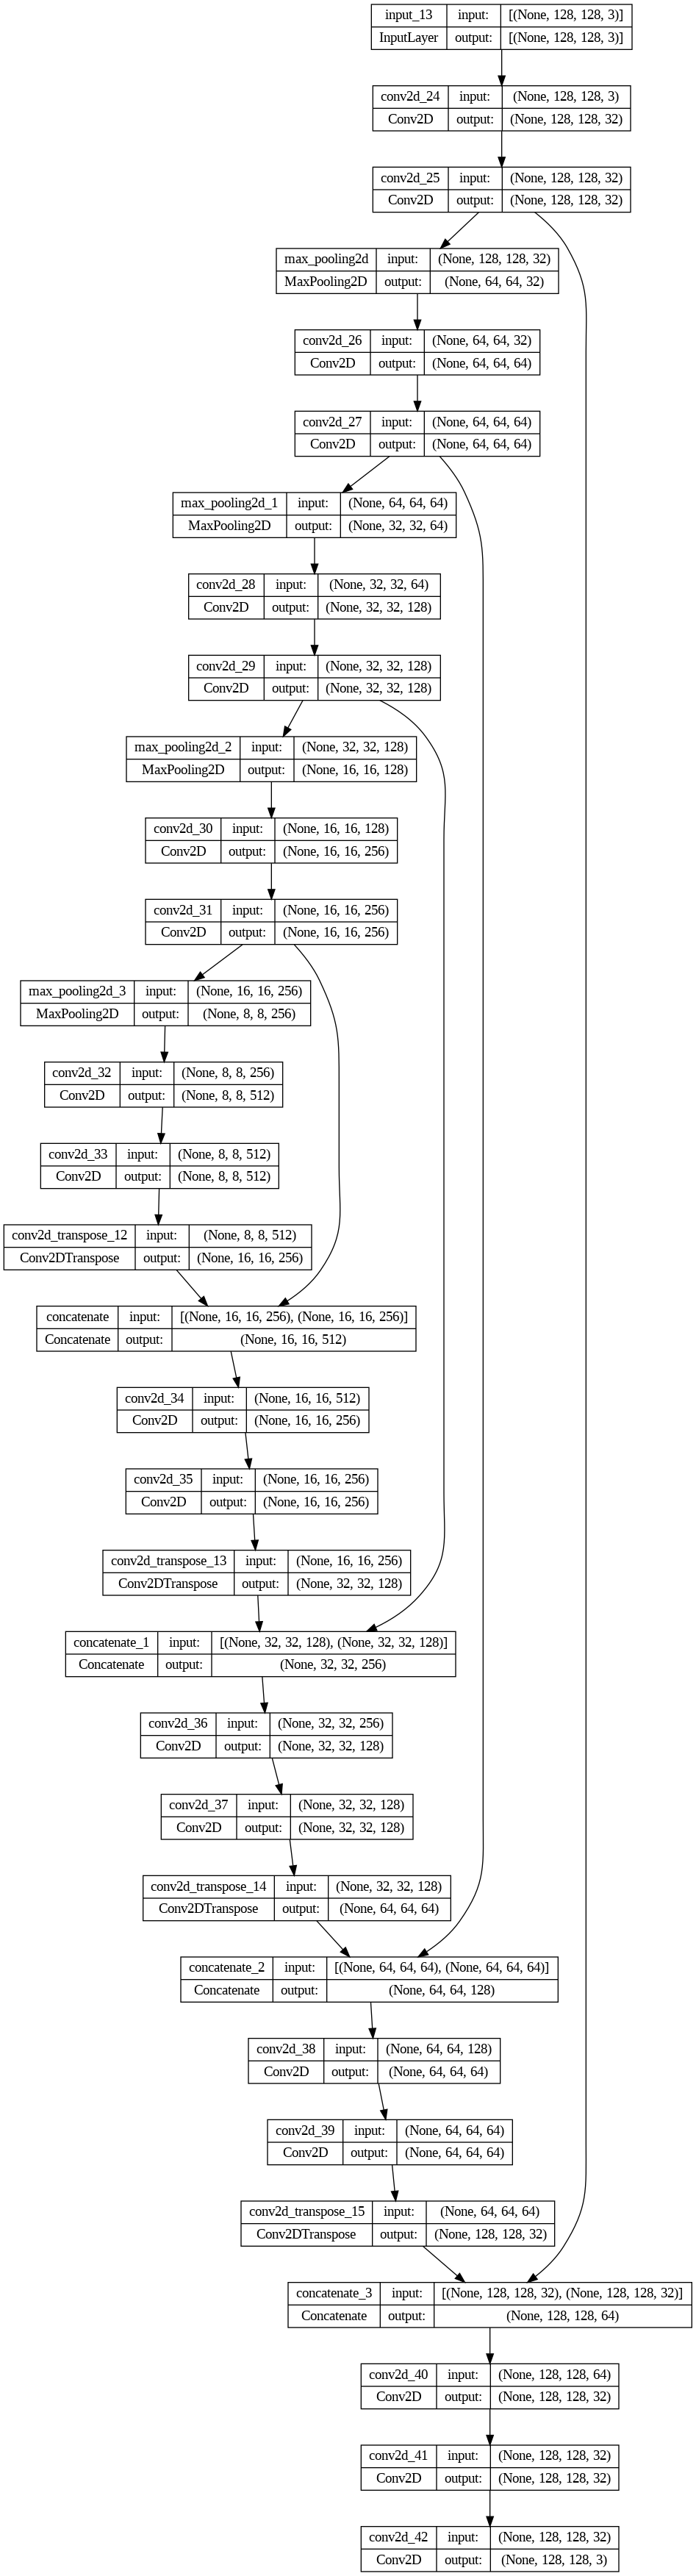

In [ ]:
tf.keras.utils.plot_model(a_models[6], show_shapes=True)

In [ ]:
for i, layer in enumerate(a_models[-1].layers):
  if 'conv' not in layer.name:
    continue
  filters, bias = layer.get_weights()
  print(i, layer.name, filters.shape)

In [ ]:
# retrieve weights from the second hidden layer
filters, bias = a_models[-1].layers[31].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 3
ix = 1
fig = plt.figure(figsize=(20, 15))
for i in range(n_filters):
  f = filters[:,:,:,i]
  for j in range(3):
    plt.subplot(n_filters, 3, ix)
    plt.title(f"{i}-th filter, {j}-th channel")
    plt.imshow(f[:,:,j], cmap='gray')
    ix += 1
fig.tight_layout()
plt.show()

## Feature Maps

In [ ]:
for image, mask in test_batches.take(1):
  pass

### FCN (Fine-Tuning & 16s)

In [ ]:
for i in range(len(a_models[3].layers)):
  layer = a_models[3].layers[i]
  if 'conv' not in layer.name:
    continue
  print(i , layer.name , layer.output.shape)

3 conv2d_10 (None, 2, 2, 512)
4 conv2d_11 (None, 2, 2, 512)
5 conv2d_12 (None, 2, 2, 3)
6 conv2d_13 (None, 16, 16, 3)
7 conv2d_transpose_4 (None, 16, 16, 3)
9 conv2d_transpose_5 (None, 128, 128, 3)


In [ ]:
blocks = [6, 9]
outputs = [a_models[3].layers[i].output for i in blocks]
temp_model = tf.keras.models.Model(inputs=a_models[3].inputs, outputs=outputs)
feature_map = temp_model.predict(image)

1/1 [==============================] - 0s 328ms/step


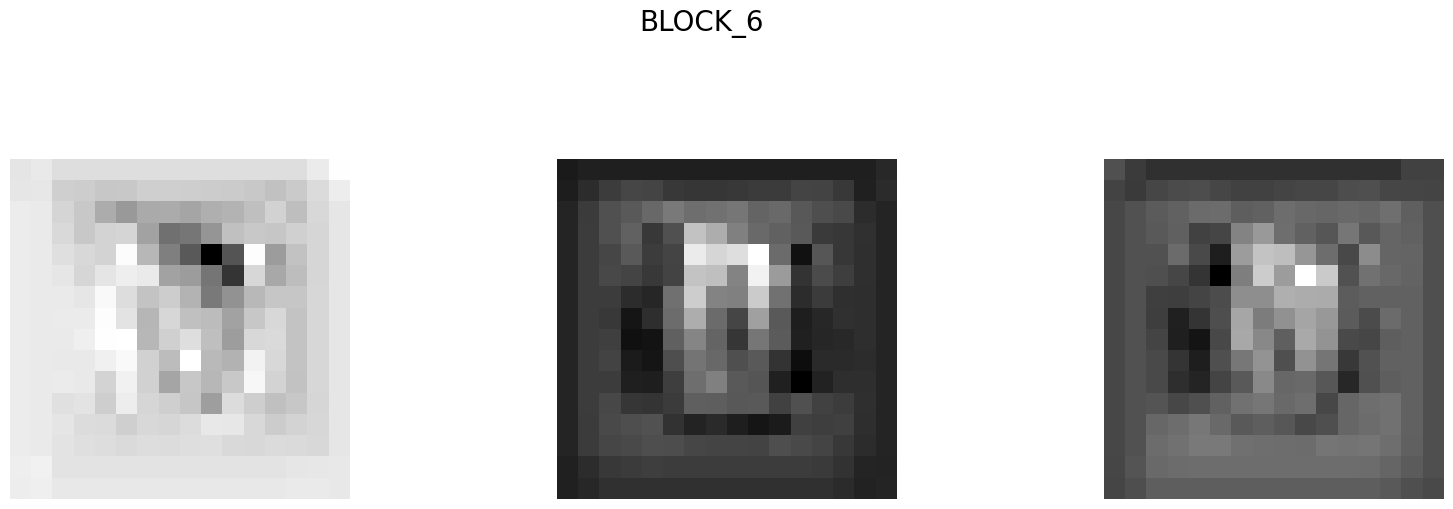

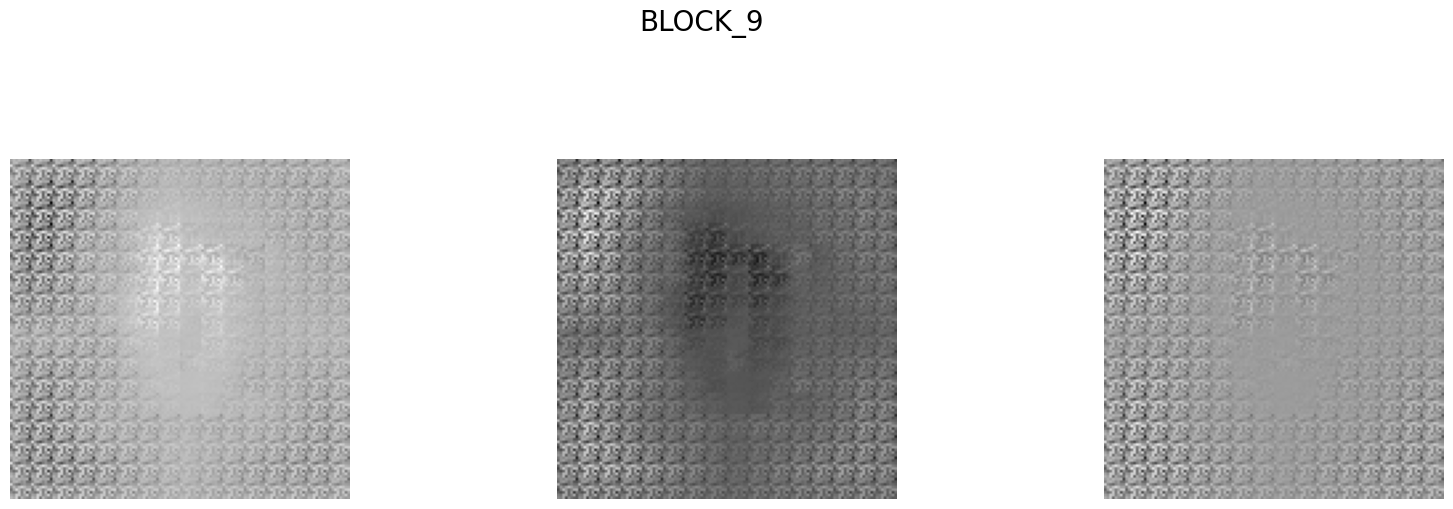

In [ ]:
for i, fmap in zip(blocks, feature_map):
  fig = plt.figure(figsize=(20,15))
  fig.suptitle("BLOCK_{}".format(i), fontsize=20)
  for i in range(1, fmap.shape[3]+1):
    plt.subplot(int(np.sqrt(fmap.shape[3]+1))+1, int(np.sqrt(fmap.shape[3]+1))+1, i)
    plt.imshow(fmap[0,:,:,i-1] , cmap='gray') 
    plt.axis('off')
plt.show()

### FCN (Feature Extractor & 16s)

In [ ]:
for i in range(len(a_models[2].layers)):
  layer = a_models[2].layers[i]
  if 'conv' not in layer.name:
    continue
  print(i , layer.name , layer.output.shape)

3 conv2d_6 (None, 2, 2, 512)
4 conv2d_7 (None, 2, 2, 512)
5 conv2d_8 (None, 2, 2, 3)
6 conv2d_9 (None, 16, 16, 3)
7 conv2d_transpose_2 (None, 16, 16, 3)
9 conv2d_transpose_3 (None, 128, 128, 3)


In [ ]:
blocks = [6, 9]
outputs = [a_models[2].layers[i].output for i in blocks]
temp_model = tf.keras.models.Model(inputs=a_models[2].inputs, outputs=outputs)
feature_map = temp_model.predict(image)

1/1 [==============================] - 0s 459ms/step


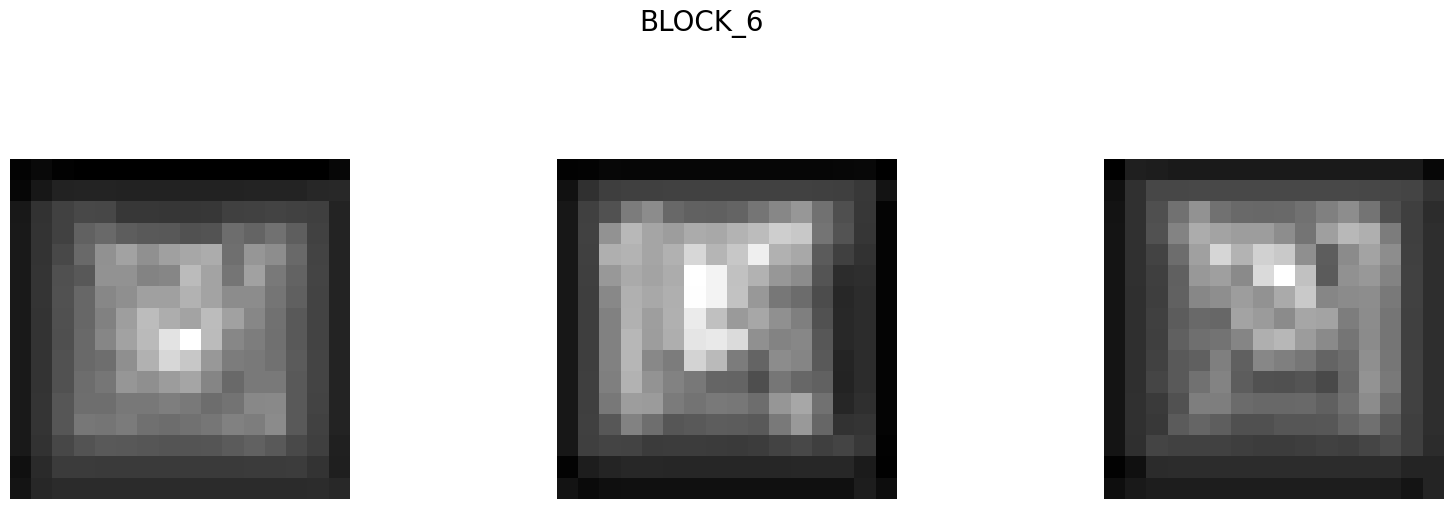

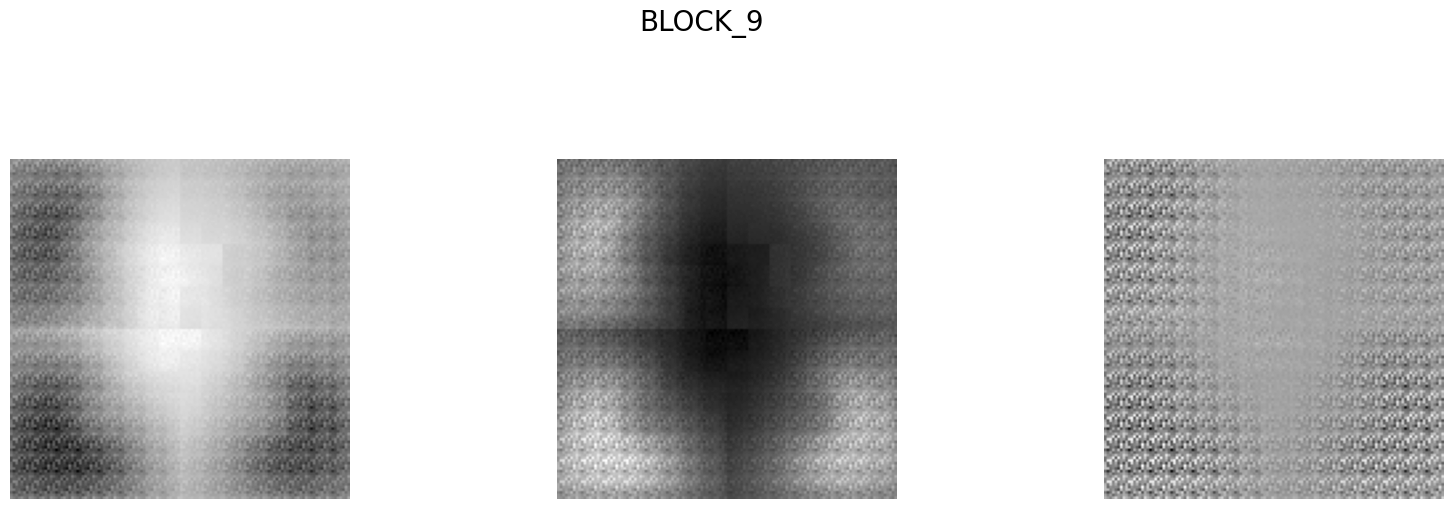

In [ ]:
for i, fmap in zip(blocks, feature_map):
  fig = plt.figure(figsize=(20,15))
  fig.suptitle("BLOCK_{}".format(i), fontsize=20)
  for i in range(1, fmap.shape[3]+1):
    plt.subplot(int(np.sqrt(fmap.shape[3]+1))+1, int(np.sqrt(fmap.shape[3]+1))+1, i)
    plt.imshow(fmap[0,:,:,i-1] , cmap='gray') 
    plt.axis('off')
plt.show()

### UNet

In [ ]:
for i in range(len(a_models[6].layers)):
  layer = a_models[6].layers[i]
  if 'conv' not in layer.name:
    continue
  print(i , layer.name , layer.output.shape)

1 conv2d_24 (None, 128, 128, 32)
2 conv2d_25 (None, 128, 128, 32)
4 conv2d_26 (None, 64, 64, 64)
5 conv2d_27 (None, 64, 64, 64)
7 conv2d_28 (None, 32, 32, 128)
8 conv2d_29 (None, 32, 32, 128)
10 conv2d_30 (None, 16, 16, 256)
11 conv2d_31 (None, 16, 16, 256)
13 conv2d_32 (None, 8, 8, 512)
14 conv2d_33 (None, 8, 8, 512)
15 conv2d_transpose_12 (None, 16, 16, 256)
17 conv2d_34 (None, 16, 16, 256)
18 conv2d_35 (None, 16, 16, 256)
19 conv2d_transpose_13 (None, 32, 32, 128)
21 conv2d_36 (None, 32, 32, 128)
22 conv2d_37 (None, 32, 32, 128)
23 conv2d_transpose_14 (None, 64, 64, 64)
25 conv2d_38 (None, 64, 64, 64)
26 conv2d_39 (None, 64, 64, 64)
27 conv2d_transpose_15 (None, 128, 128, 32)
29 conv2d_40 (None, 128, 128, 32)
30 conv2d_41 (None, 128, 128, 32)
31 conv2d_42 (None, 128, 128, 3)


In [ ]:
blocks = [30, 31]
outputs = [a_models[-1].layers[i].output for i in blocks]
temp_model = tf.keras.models.Model(inputs=a_models[-1].inputs, outputs=outputs)
feature_map = temp_model.predict(image)

1/1 [==============================] - 0s 301ms/step


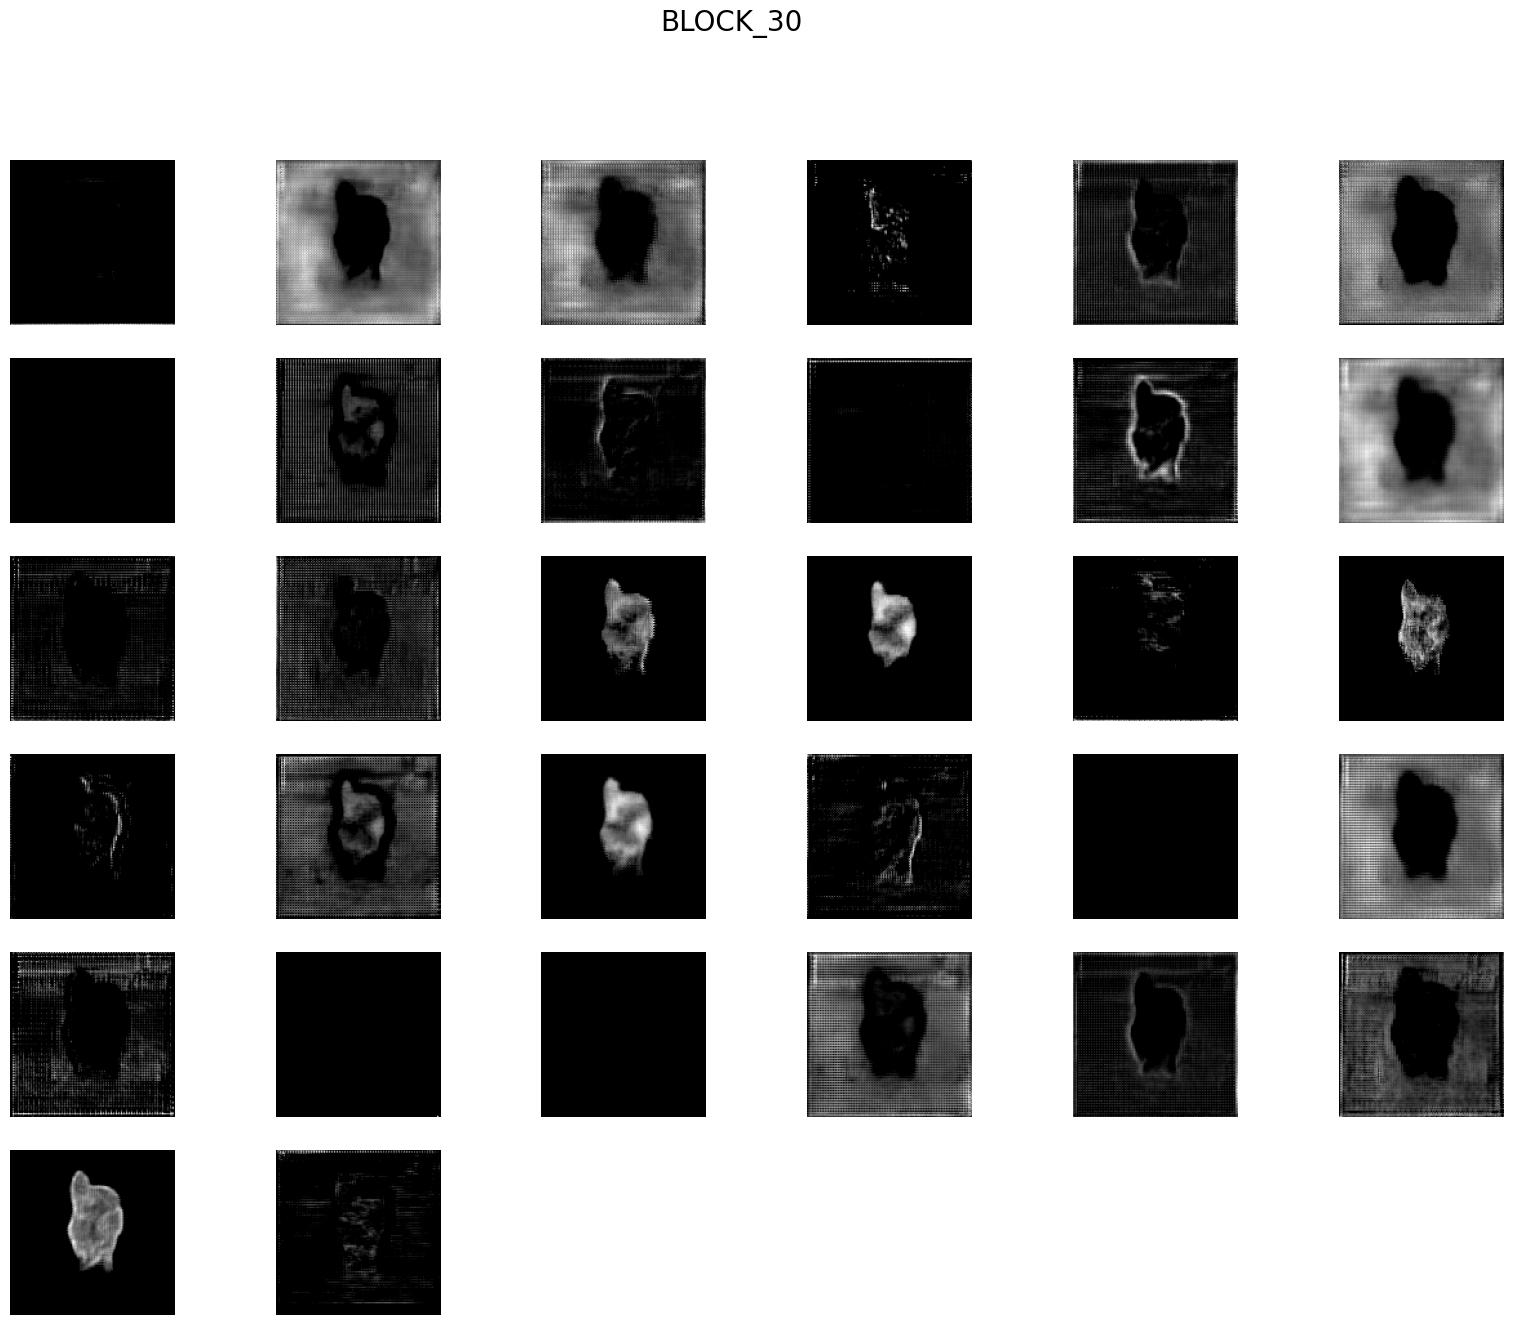

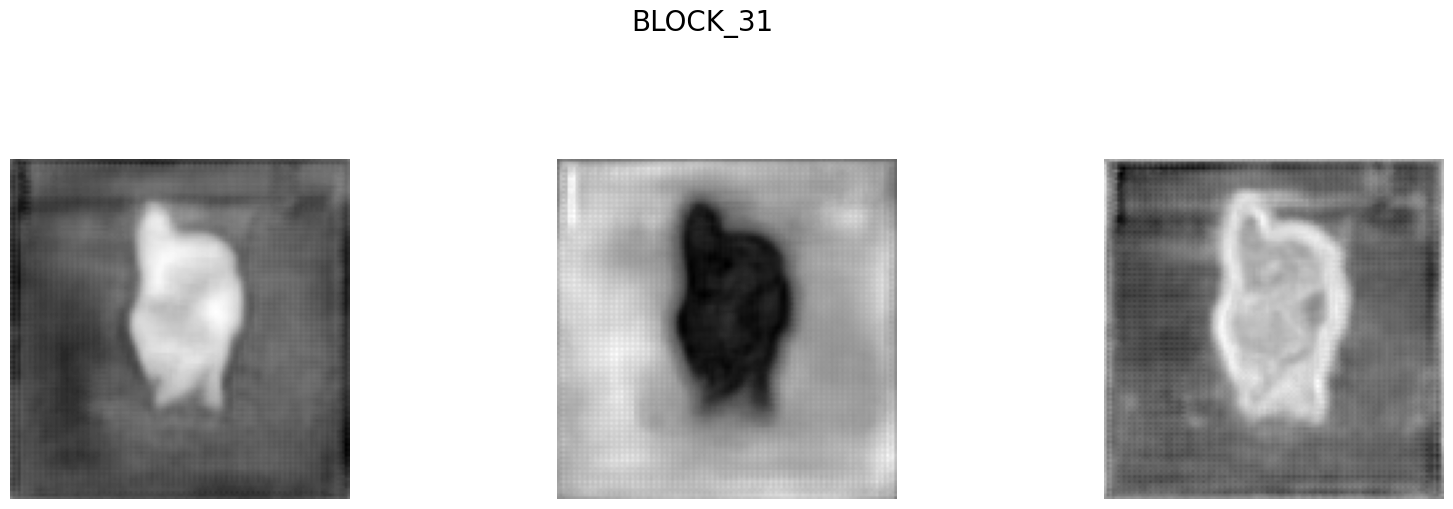

In [ ]:
for i, fmap in zip(blocks, feature_map):
  fig = plt.figure(figsize=(20,15))
  fig.suptitle("BLOCK_{}".format(i), fontsize=20)
  for i in range(1, fmap.shape[3]+1):
    plt.subplot(int(np.sqrt(fmap.shape[3]+1))+1, int(np.sqrt(fmap.shape[3]+1))+1, i)
    plt.imshow(fmap[0,:,:,i-1] , cmap='gray') 
    plt.axis('off')
plt.show()

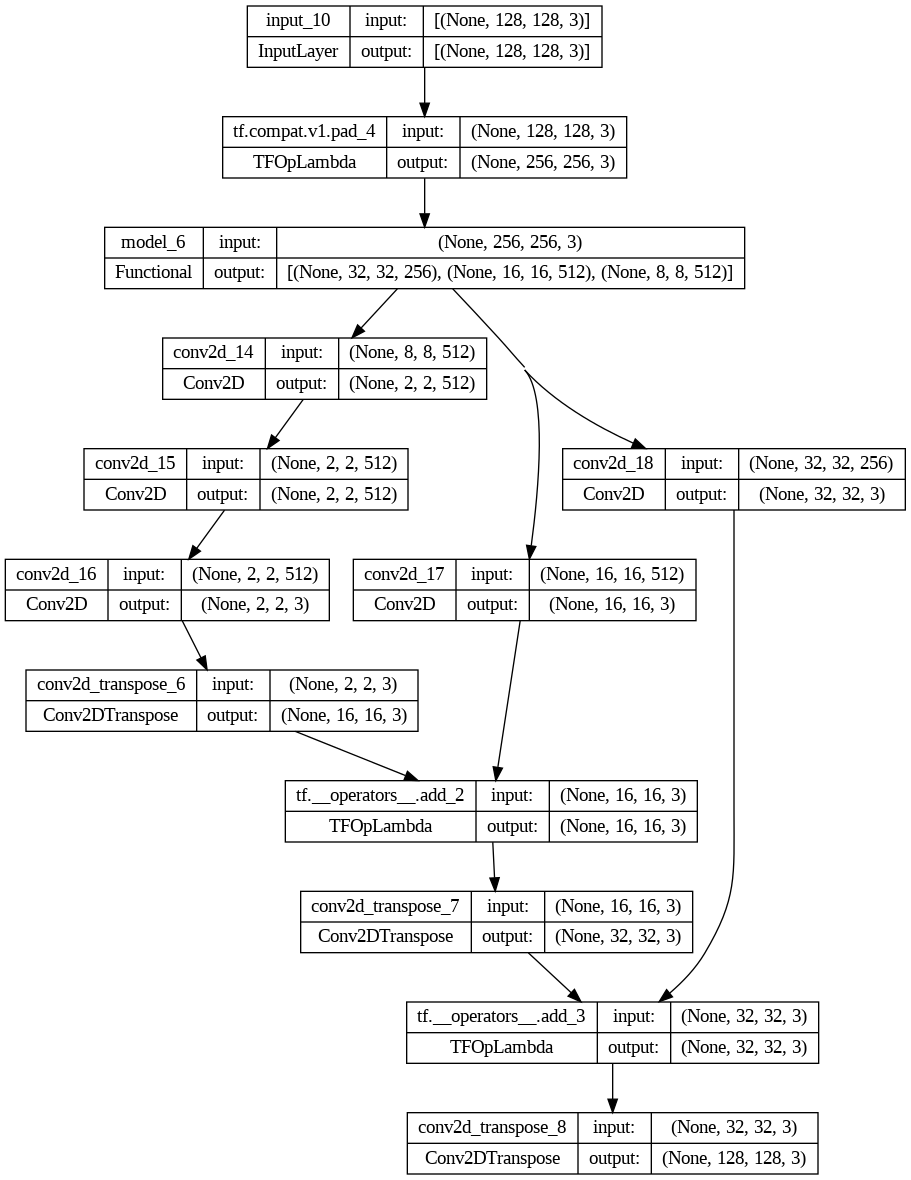

In [ ]:
tf.keras.utils.plot_model(a_models[4], show_shapes=True)